In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils.np_utils import to_categorical

from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.preprocessing import LabelEncoder  
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras import layers

from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU,Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten,GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

from keras.models import Model
from keras.optimizers import RMSprop
plt.style.use('fivethirtyeight')


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data = pd.read_excel('/content/drive/My Drive/Master thesis/DataSet-forUsing/4-hate_speech_mlma_ar_dataset.xlsx')
print("Sample from dataset",data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3353 entries, 0 to 3352
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           3353 non-null   int64 
 1   tweet                3345 non-null   object
 2   sentiment            3353 non-null   object
 3   directness           3353 non-null   object
 4   annotator_sentiment  3353 non-null   object
 5   target               3353 non-null   object
 6   group                3353 non-null   object
dtypes: int64(1), object(6)
memory usage: 183.5+ KB
Sample from dataset None


In [7]:
data.head()

,Unnamed: 0,tweet,sentiment,directness,annotator_sentiment,target,group
0,1,صلاة الفجر خير لك من ترديد بول البعير وسبي الن...,hateful_normal,indirect,shock,gender,individual
1,2,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...,offensive,indirect,anger_confusion_sadness_indifference_disgust,other,other
2,3,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...,offensive,indirect,indifference,other,individual
3,4,@user @user انا اوافقك بخصوص السوريين و العراق...,normal,direct,indifference,origin,other
4,5,هذه السعودية التي شعبها شعب الخيم و بول البعير...,normal,indirect,indifference,origin,other


In [8]:
data.isna().sum()

Unnamed: 0             0
tweet                  8
sentiment              0
directness             0
annotator_sentiment    0
target                 0
group                  0
dtype: int64

In [9]:
data.shape

(3353, 7)

In [10]:
data.dropna(axis=0,inplace=True)

In [11]:
data.shape

(3345, 7)

In [12]:
data["tweet"].duplicated().sum()

12

In [13]:
bool_series = data["tweet"].duplicated() 
data[bool_series][:12]

,Unnamed: 0,tweet,sentiment,directness,annotator_sentiment,target,group
253,254,تحمل اللاجئون السوريون شدة البرد والحر,normal,direct,sadness,origin,refugees
803,804,فتوى جديدة من #العراق يجوز شرب بول البعير وبول...,abusive_disrespectful,indirect,indifference_disgust,origin,other
1309,1310,على مهلك خدينك بحلمك لوين يا رامز لجوا له ولي ...,offensive,indirect,indifference,origin,other
1696,1697,يبدو أنّك تحت تأثير بول البعير,abusive_disrespectful,direct,indifference,origin,individual
1823,1824,في الزلفي بايرة المرأة التي لم تتزوج أو التي ل...,offensive,indirect,indifference,other,women
2096,2097,معاك ريال تسوين ريال,disrespectful,indirect,sadness,other,individual
2122,2123,وانتي متبرجة مثيرة للشفقة,hateful_disrespectful_normal,direct,indifference,other,individual
2175,2176,ما بدي كون متطفّل,normal,direct,indifference,other,other
2263,2264,لا للتصنيف عندما يتوقف تصنيف التي لم تتزوج بال...,normal,indirect,shock,gender,women
2519,2520,مع إني ضد الشتيمة,normal,direct,indifference,origin,individual


In [14]:
data.loc[data['tweet'] == "تحمل اللاجئون السوريون شدة البرد والحر"]

,Unnamed: 0,tweet,sentiment,directness,annotator_sentiment,target,group
151,152,تحمل اللاجئون السوريون شدة البرد والحر,normal,direct,sadness_indifference,origin,refugees
253,254,تحمل اللاجئون السوريون شدة البرد والحر,normal,direct,sadness,origin,refugees


In [15]:
data.shape

(3345, 7)

In [16]:
data.drop_duplicates(subset=['tweet'],inplace=True)

In [17]:
len(data.sentiment.unique())

36

In [18]:
data.sentiment.value_counts()

offensive                                          946
normal                                             907
hateful                                            459
abusive_disrespectful                              203
abusive_hateful                                    168
disrespectful                                      165
disrespectful_normal                               103
abusive_normal                                      81
abusive_offensive                                   76
hateful_disrespectful                               40
offensive_disrespectful                             32
abusive_offensive_hateful_disrespectful_normal      23
offensive_normal                                    21
abusive                                             19
hateful_normal                                      15
fearful                                             12
offensive_hateful                                   11
abusive_offensive_disrespectful_hateful_normal      10
fearful_ab

In [19]:
data_df=data[['tweet', 'sentiment']]

In [20]:
data_df.shape

(3333, 2)

In [21]:
data_df["sentiment"] = data_df.apply(lambda x: "Not-HS" if x["sentiment"] == 'normal' else "HS",axis =1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
data_df.head()

,tweet,sentiment
0,صلاة الفجر خير لك من ترديد بول البعير وسبي الن...,HS
1,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...,HS
2,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...,HS
3,@user @user انا اوافقك بخصوص السوريين و العراق...,Not-HS
4,هذه السعودية التي شعبها شعب الخيم و بول البعير...,Not-HS


In [23]:
data_df.sentiment.value_counts()

HS        2426
Not-HS     907
Name: sentiment, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of Hate and Normal tweets')

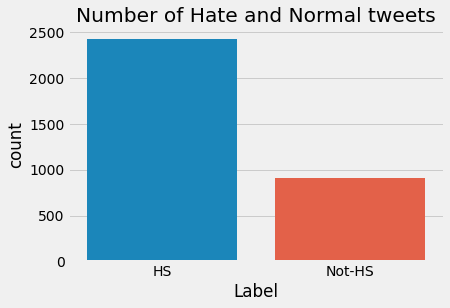

In [24]:


sns.countplot(data_df.sentiment)
plt.xlabel('Label')
plt.title('Number of Hate and Normal tweets')

In [25]:


le = LabelEncoder()   
data_df['sentiment']= le.fit_transform(data_df['sentiment']) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [26]:
data_df.head()

,tweet,sentiment
0,صلاة الفجر خير لك من ترديد بول البعير وسبي الن...,0
1,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...,0
2,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...,0
3,@user @user انا اوافقك بخصوص السوريين و العراق...,1
4,هذه السعودية التي شعبها شعب الخيم و بول البعير...,1


In [27]:
val_df = data_df.sample(frac=0.1, random_state=1007)
train_df = data_df.drop(val_df.index)
test_df = train_df.sample(frac=0.1, random_state=1007)
train_df.drop(test_df.index, inplace=True)
(train_df.shape,val_df.shape,test_df.shape)

((2700, 2), (333, 2), (300, 2))

In [28]:
x_train=train_df['tweet']
y_train=train_df['sentiment']
x_val=val_df['tweet']
y_val=val_df['sentiment']
x_test=test_df['tweet']
y_test=test_df['sentiment']

In [29]:
x_train.head()

0    صلاة الفجر خير لك من ترديد بول البعير وسبي الن...
1    صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...
2    طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...
3    @user @user انا اوافقك بخصوص السوريين و العراق...
5    ما عارف كنت شايفها منحرفة شديد وانا صغير ليه @url
Name: tweet, dtype: object

In [30]:

#prepare a tokenizer for abstract on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

#convert abstract sequences into integer sequences
x_train   =   x_tokenizer.texts_to_sequences(x_train) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)
x_test = x_tokenizer.texts_to_sequences(x_test)
#padding zero upto maximum length
x_train    =   pad_sequences(x_train, padding='post') 
x_val     =   pad_sequences(x_val, padding='post')
x_test = pad_sequences(x_test,padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1
print("Size of vocabulary in x = {}".format(x_voc_size))

Size of vocabulary in x = 12366


In [31]:
x_train[:1]

array([[1595, 1596, 1057,   87,    3, 3185,    4,    5, 3186,  282, 3187,
        3188, 3189, 3190, 3191, 3192,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [32]:

x_train.shape

(2700, 29)

# First model | Bidirectional RNN

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(x_voc_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1582848   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,727,170
Trainable params: 1,727,170
Non-trainable params: 0
______________________________________________

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience=10)

history=model.fit(x_train, y_train, epochs=100, batch_size=128,callbacks=[es])


Epoch 1/50
22/22 [==============================] - 3s 140ms/step - loss: 3.3706 - accuracy: 0.4800
Epoch 2/50
22/22 [==============================] - 3s 139ms/step - loss: 3.3962 - accuracy: 0.5356
Epoch 00002: early stopping


In [58]:
y_predict = model.predict(x_test)
# print(y_predict)
# predictions = (np.array(y_predict) > 0.5).astype(np.int)
np.array(y_predict).astype(np.int).flatten().tolist()


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


# Second Model  | CNN +GRU

In [59]:
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.optimizers import Adam

model2= Sequential()
model2.add(Embedding(x_voc_size,128,input_length= x_train.shape[1]))
model2.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.25))
model2.add(GRU(128,return_sequences=True))
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 128)           1582848   
_________________________________________________________________
conv1d (Conv1D)              (None, 29, 64)            24640     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 14, 128)           74496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)             

In [60]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1)

history=model2.fit(x_train, y_train, epochs=10, batch_size=128,callbacks=[es])


Epoch 1/10
22/22 [==============================] - 2s 73ms/step - loss: 0.6933 - accuracy: 0.5100
Epoch 2/10
22/22 [==============================] - 2s 73ms/step - loss: 0.6931 - accuracy: 0.5707
Epoch 3/10
22/22 [==============================] - 2s 73ms/step - loss: 0.6931 - accuracy: 0.5726
Epoch 4/10
22/22 [==============================] - 2s 72ms/step - loss: 0.6931 - accuracy: 0.5526
Epoch 5/10
22/22 [==============================] - 2s 73ms/step - loss: 0.6931 - accuracy: 0.5619
Epoch 00005: early stopping


# Third Model | Bidirectional GRU

In [61]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(x_voc_size, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=False)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model3.summary()
model3.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
es = EarlyStopping(monitor='loss', mode='min', verbose=1)
history=model3.fit(x_train, y_train, epochs=10,batch_size=128,callbacks=[es])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1582848   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         198144    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 2,077,954
Trainable params: 2,077,954
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22/22 [==============================] - 8s 362ms/step - loss: 0.6936 - accuracy: 0.4481
Epoch 2/10

# Forth Model | LSTM

In [ ]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(x_voc_size, 128),
    tf.keras.layers.SpatialDropout1D(0.4),
    tf.keras.layers.LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True),
    tf.keras.layers.LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False),
    tf.keras.layers.Dense(2,activation='softmax')
])
model4.summary()
model4.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
es = EarlyStopping(monitor='loss', mode='min', verbose=1)
history=model4.fit(x_train, y_train, epochs=10,batch_size=128,callbacks=[es])
# model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
# model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         1582848   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,644,738
Trainable params: 1,644,738
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22/22 [==============================] - 3s 155ms/step - loss: 0.6933 - accuracy: 0.5226
Epoch 2/10